# SES722 - Projet d'Econométrie

## Partie 1: Régression

Réalisation: **Anatoli de BRADKE** et **Raphael LEDERMAN**

Date: **Avril 2019**

## Imports généraux

In [1]:
# General
import numpy as np
import pandas as pd
import itertools
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from pandas import datetime
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

# Graph
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import seaborn as sns

# Statistics
from scipy import stats
import statsmodels.api as sm

from statsmodels.discrete.discrete_model import Probit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Question 1
Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes)

In [4]:
file_name = '../../quarterly.xls'
df = pd.read_excel(file_name, sheetname='TB3MS')
print(df.isna().sum())
print('Nombre total d\'observations manquantes : {}'.format(df.isna().sum().sum()))

DATE        0
FFR         0
Tbill       0
Tb1yr       0
r5          0
r10         0
PPINSA      0
Finished    0
CPI         0
CPICORE     0
M1NSA       0
M2SA        0
M2NSA       0
Unemp       0
IndProd     0
RGDP        0
Potent      0
Deflator    0
Curr        0
dtype: int64
Nombre total d'observations manquantes : 0


In [5]:
df['YEAR'] = df["DATE"].str.slice(stop=4)
df["QUARTER"] = df["DATE"].str.slice(start=5).astype(int)*3
df["QUARTER"] = np.where(df['QUARTER'].map(str).map(len) ==1, "0"+df["QUARTER"].map(str), df["QUARTER"].map(str))
df['DATE'] = df["YEAR"] + " " + df['QUARTER'].map(str)
df['DATE'].apply(lambda x: datetime.strptime(x, '%Y %m'))
df = df.drop(['YEAR', 'QUARTER'], axis = 1)

## Question 2
Calculer inf, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de inf. Commentez.

In [6]:
df['inf'] = (df['CPI']- df['CPI'].shift(1))/df['CPI']

In [95]:
import matplotlib.dates as mdate
def plot_dataframe_cols(dataframe, cols, labels, title, colors = ['cornflowerblue', 'deepskyblue', 'mediumslateblue', 'violet']):
    fig, ax = plt.subplots(figsize=(20,10))
    num_curves = len(cols)
    for i, el in enumerate(cols):
        ax.plot(dataframe['DATE'], dataframe[el], label=labels[i], color = colors[i])
    ax.legend(loc='upper right')
    ax.set(xlabel="Date", ylabel="%")
    ax.set(title='{}'.format(title))
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(fontsize = 12, rotation=60)
        plt.yticks(fontsize = 12)
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.yaxis.set_major_locator(plt.MaxNLocator(20))


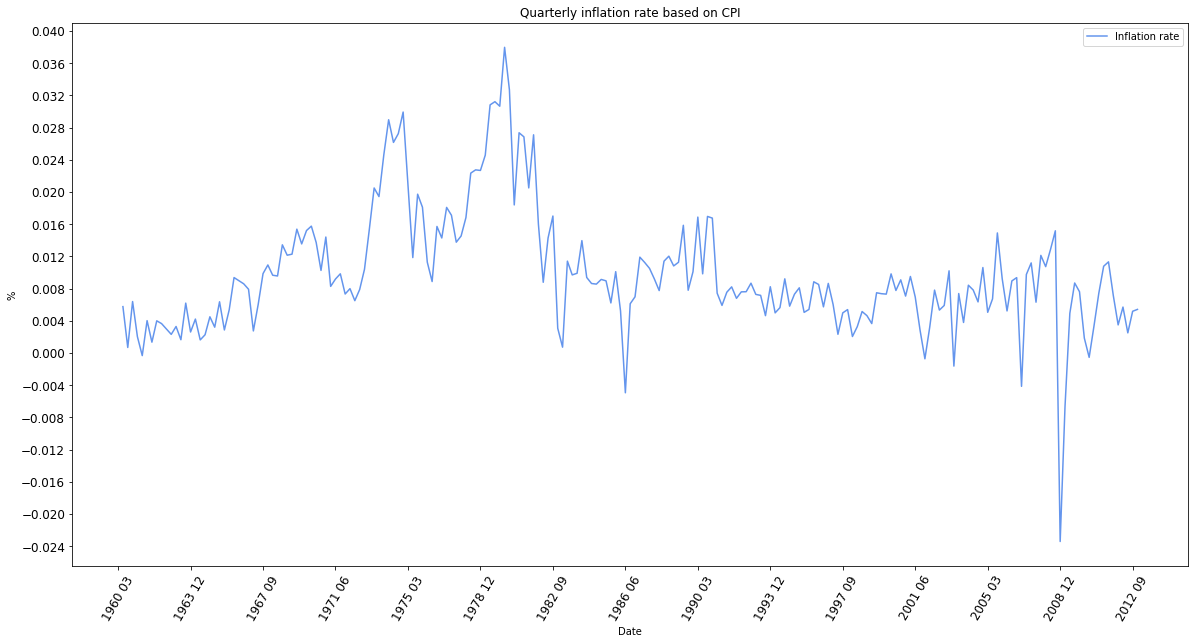

In [96]:
plot_dataframe_cols(df, ['inf'], ['Inflation rate'], 'Quarterly inflation rate based on CPI')

## Question 3
Interpréter l'autocorrélogramme et l'autocorrélogrammes partiels de inf. Quelle est la différence entre ces deux graphiques ?

[Text(0.5,1,'Inflation PACF')]

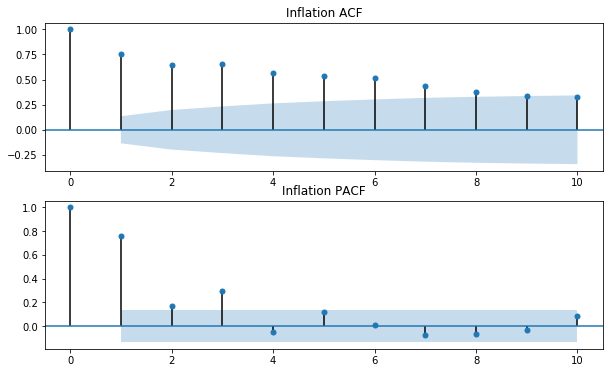

In [97]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(df["inf"].dropna(), lags=10, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(df["inf"].dropna(), lags=10, ax=ax2)
ax1.set(title='{}'.format("Inflation ACF"))
ax2.set(title='{}'.format("Inflation PACF"))

## Question 4
Quelle est la différence entre la stationnarité et l'ergodicité ? Pourquoi a-t-on besoin de ces deux conditions. Expliquez le terme "spurious regression".

> **Ergodicité** : la valeur moyenne d'une grandeur calculée de manière statistique est égale à la moyenne d'un très grand nombre de mesures prises dans le temps. Un processus ergodique est un processus stochastique pour lequel les statistiques peuvent être approchées par l'étude d'une seule réalisation suffisamment longue.
La question sous-jacente à la notion d'ergodicité est la suivante : est-ce que les moyennes statistiques sont égales aux moyennes temporelles ? Ou encore : est-ce qu’une seule réalisation x(t) caractérise complètement le
processus stochastique X(t) ?

> **Stationnarité** : la structure du processus sous-jacent reste la même à travers le temps.
La question sous-jacente à la notion d'ergodicité est la suivante : est-ce que les propriétés statistiques changent avec le temps ?

## Question 5
Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours.

In [98]:
def compute_ARIMA(data,col='inf', order_arima = (5, 0, 0)):
    series = data[col].dropna()
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order_arima)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return history, model_fit, ARMAResults.aic(model_fit),ARMAResults.bic(model_fit), ARMAResults.hqic(model_fit) 

In [99]:
orders = [(1,0,0), (2,0,0), (3,0,0), (4,0,0), (5,0,0), (6,0,0), (7,0,0), (8,0,0)]
best_model = (0,0,0)
best_model_score = 10000
for order in orders:
    ts, fit, aic, bic, hqic = compute_ARIMA(df, col = 'inf', order_arima=order)
    if (aic+bic+hqic)/3 < best_model_score:
        best_model =order
        best_model_score = (aic+bic+hqic)/3
ts, fit, aic, bic, hqic =compute_ARIMA(df, col = 'inf', order_arima=best_model)
print(ARMAResults.summary(fit))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  210
Model:                     ARMA(3, 0)   Log Likelihood                 829.318
Method:                       css-mle   S.D. of innovations              0.005
Date:                Thu, 25 Apr 2019   AIC                          -1648.635
Time:                        15:18:34   BIC                          -1631.900
Sample:                             0   HQIC                         -1641.870
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.002      4.407      0.000       0.005       0.013
ar.L1.y        0.5742      0.066      8.737      0.000       0.445       0.703
ar.L2.y       -0.0137      0.077     -0.178      0.8

## Question 6
Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation courant et une constante.

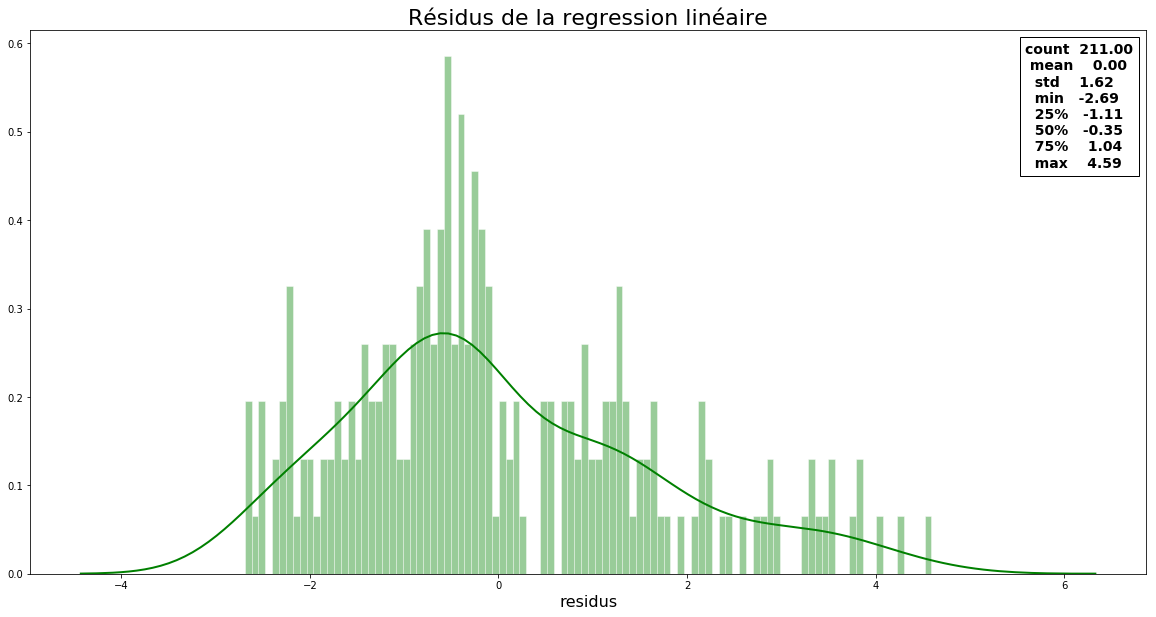

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.008229
Date:                Sun, 28 Apr 2019   Prob (F-statistic):              0.928
Time:                        19:38:41   Log-Likelihood:                -400.28
No. Observations:                 211   AIC:                             804.6
Df Residuals:                     209   BIC:                             811.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0735      0.182     33.388      0.0

In [15]:
def plot_hist(x, x_label, title, bins=50, kde=False, color='green', edge='white', linewidth=2, figsize=(20,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    sns.distplot(x, hist=True, kde=kde, bins=bins, color = color,
                 hist_kws={'edgecolor':edge}, kde_kws={'linewidth': linewidth})
    plt.title(title, fontsize=22)
    plt.xlabel(x_label, fontsize=16)
    ob = offsetbox.AnchoredText(round(x.describe(), 2).reset_index().to_string(header=None, index=None),
                                prop={'fontweight':"bold", 'size': 14},  
                                loc=1)
    ax.add_artist(ob)
    plt.show()

# Regression lineaire 
df = df.dropna()
Y = df['Unemp']
X = df['inf']
ols = sm.OLS(Y, sm.add_constant(X)).fit()

# Histogramme des résidus
df['residus']= ols.resid
plot_hist(df['residus'], 'residus', "Résidus de la regression linéaire", bins=100, kde=True)

# OLS summary
print(ols.summary())

In [16]:
df.residus

1     -0.851185
2     -0.544369
3      0.187967
4      0.723837
5      0.926990
6      0.691156
7      0.124747
8     -0.448816
9     -0.548352
10    -0.507450
11    -0.546557
12    -0.307869
13    -0.345661
14    -0.581771
15    -0.506951
16    -0.609108
17    -0.875629
18    -1.076490
19    -1.109492
20    -1.177755
21    -1.411995
22    -1.707290
23    -1.980655
24    -2.216038
25    -2.255509
26    -2.314994
27    -2.384086
28    -2.247129
29    -2.251562
30    -2.286697
         ...   
182   -1.123485
183   -1.115852
184   -1.350466
185   -1.455477
186   -1.456026
187   -1.637883
188   -1.586547
189   -1.588482
190   -1.411926
191   -1.289738
192   -1.087859
193   -0.760728
194   -0.093843
195    0.828017
196    2.205521
197    3.219931
198    3.544872
199    3.846323
200    3.754067
201    3.557281
202    3.422040
203    3.446568
204    2.912076
205    2.941342
206    2.916975
207    2.591862
208    2.188887
209    2.093192
210    1.949588
211    1.749277
Name: residus, Length: 2

## Question 7
Tester l’autocorrélation des erreurs.

In [22]:
def test_autocorrelation(residuals):
    #Perform Durbin-Watson test:
    dwtest = durbin_watson(residuals)
    print ('Results of Durbin-Watson Test : {}'.format(dwtest)) 

In [23]:
test_autocorrelation(df['residus'])

Results of Durbin-Watson Test : 0.0441186915347716


La p-value est strictement inférieure à 5%. Cette valeur significativement petite permet de remettre en question la validité de l'hypothèse : il peut exister une autocorrelation dans les résidus de la régression.

## Question 8
Corriger l’autocorrélation des erreurs par la méthode vue en cours.

In [24]:
# Calcul du rho
Y = df['residus'][1:]
X = df['residus'].shift(1)[1:]
ols = sm.OLS(Y, X).fit()
rho = ols.params[0]

# Calcul des quasi-differences
y_quasi_difference = [0]* df['Unemp'].shape[0]
y_quasi_difference[0] = np.sqrt(1-rho**2)*df['Unemp'].iloc[0]
X_quasi_difference = [0]* df['Unemp'].shape[0]
X_quasi_difference[0] = np.sqrt(1-rho**2)*df['inf'].iloc[0]
for i in range(1,len(y_quasi_difference)):
    y_quasi_difference[i]= df['Unemp'].iloc[i] - rho * df['Unemp'].iloc[i-1]
    X_quasi_difference[i]= df['inf'].iloc[i] - rho * df['inf'].iloc[i-1]
df['Unemp_quasi_difference'] = y_quasi_difference
df['inf_quasi_difference'] = X_quasi_difference
# Calcul des résidus de la regression lineaire ordinaire après quasi-différence
df = df.dropna()
Y = y_quasi_difference
X = X_quasi_difference
ols = sm.OLS(Y, sm.add_constant(X)).fit()
df['residus_quasi_difference']= ols.resid

# Test autocorrelation des résidus
test_autocorrelation(df['residus_quasi_difference'])

Results of Durbin-Watson Test : 0.7165627406233386


La p-value a augmenté significativement et semble indiquer qu'il n'y a pas d'autocorrélation dans les résidus.

## Question 9
Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique.

In [25]:
# On échantillonne deux périodes de durée égale
# Première sous-période
df_1 = df.iloc[0:50,:]
Y = df_1['Unemp_quasi_difference']
X = df_1[['inf_quasi_difference']]
ols = sm.OLS(Y, sm.add_constant(X)).fit()
SSR_1 = np.sum(ols.resid ** 2)
ddl_1 = df_1.shape[0] - X.shape[1] - 1

# Deuxième sous-période
df_2= df.iloc[-50:,:]
Y = df_2['Unemp_quasi_difference']
X = df_2[['inf_quasi_difference']]
ols = sm.OLS(Y, sm.add_constant(X)).fit()
SSR_2 = np.sum(ols.resid ** 2)
ddl_2 = df_2.shape[0] - X.shape[1] - 1

# Modèle non contraint
Y = df['Unemp_quasi_difference']
X = df[['inf_quasi_difference']]
ols = sm.OLS(Y, sm.add_constant(X)).fit()
SSR_nc = np.sum(ols.resid ** 2)
ddl_nc = df.shape[0] - X.shape[1] - 1

# Statistique de test de Chow
F = ((SSR_nc - (SSR_1 + SSR_2))/ (ddl_nc - (ddl_1 + ddl_2))) / ((SSR_1 + SSR_2) / (ddl_1 + ddl_2))

# Seuil de validité du test à 5%
F_threshold = stats.f.ppf(0.95, ddl_nc - (ddl_1 + ddl_2), ddl_1 + ddl_2)
p_value = stats.f.cdf(F, ddl_nc - (ddl_1 + ddl_2), ddl_1 + ddl_2)

# Test de l'hypothese H0: SSR_nc = SSR_1 + SSR_2
print("Peut-on rejeter l'hypothèse [H0: Pas de rupture de tendance]: {}".format(F > F_threshold))
print("p-value: {}%".format(round(100 * p_value)))

Peut-on rejeter l'hypothèse [H0: Pas de rupture de tendance]: False
p-value: 63.0%


## Question 10
Faites les tests changement de structure de Chow et détecter le point de rupture.

In [26]:
df.shape

(211, 24)

In [28]:
# Modèle non contraint
Y = df['Unemp_quasi_difference']
X = df[['inf_quasi_difference']]
ols = sm.OLS(Y, sm.add_constant(X)).fit()
SSR_nc = np.sum(ols.resid ** 2)
ddl_nc = df.shape[0] - X.shape[1] - 1

# Modèles contraints
test_list = []
n = df.shape[0]
for i in range(int(0.15*n), int(0.85*n)):
    
    # Première période
    df_1 = df.iloc[0:i,:]
    Y = df_1['Unemp_quasi_difference']
    X = df_1[['inf_quasi_difference']]
    
    ols = sm.OLS(Y, sm.add_constant(X)).fit()
    SSR_1 = np.sum(ols.resid ** 2)
    ddl_1 = df_1.shape[0] - X.shape[1] - 1

    # Deuxième sous-période
    df_2= df.iloc[-i:,:]
    Y = df_2['Unemp_quasi_difference']
    X = df_2[['inf_quasi_difference']]
    ols = sm.OLS(Y, sm.add_constant(X)).fit()
    SSR_2 = np.sum(ols.resid ** 2)
    ddl_2 = df_2.shape[0] - X.shape[1] - 1

    # Statistique de test de Chow
    F = ((SSR_nc - (SSR_1 + SSR_2))/ (ddl_nc - (ddl_1 + ddl_2))) / ((SSR_1 + SSR_2) / (ddl_1 + ddl_2))

    # Seuil de validité du test à 5%
    F_threshold = stats.f.ppf(0.95, ddl_nc - (ddl_1 + ddl_2), ddl_1 + ddl_2)
    p_value = stats.f.cdf(F, ddl_nc - (ddl_1 + ddl_2), ddl_1 + ddl_2)

    # Sauvegarde des valeurs
    test_list.append((i, F, F_threshold, p_value))
    
# Resultats
rupture = max(test_list,key=itemgetter(1))
print("Date de rupture: {}".format(df['DATE'].iloc[rupture[0]]))
print("Peut-on rejeter l'hypothèse [H0: Pas de rupture de tendance]: {}".format(rupture[1] > rupture[2]))
print("p-value: {}%".format(round(100 * rupture[3])))

Date de rupture: 1986 12
Peut-on rejeter l'hypothèse [H0: Pas de rupture de tendance]: True
p-value: 100.0%


In [30]:
rupture

(106, 8.417364554272078, 3.8865546128147845, 0.9958836434399566)

In [29]:
test_list

[(31, 0.7399687303341929, 1.460155658773344, 0.07544697015397775),
 (32, 0.7634889590140042, 1.4531199738197333, 0.09712770640399403),
 (33, 0.7935654255055409, 1.4465952792946268, 0.13092842000894592),
 (34, 0.8201982358860354, 1.4405388176922842, 0.16593187147022354),
 (35, 0.8490370298861318, 1.4349131041340315, 0.2092549646429771),
 (36, 0.8793816586356924, 1.429685161773447, 0.2601689452711884),
 (37, 0.8973886721255508, 1.4248258899078765, 0.292229879166202),
 (38, 0.93300258900188, 1.4203095387773101, 0.3599529203752183),
 (39, 0.9645102244961834, 1.4161132707442405, 0.42212914182085964),
 (40, 0.9441690760575814, 1.4122167918872772, 0.38169008405367344),
 (41, 0.9295669584356833, 1.4086020413650016, 0.3525610645281929),
 (42, 0.9448566994492245, 1.405252928473371, 0.3830397567894456),
 (43, 0.9074275949001233, 1.402155109317147, 0.30864833149854687),
 (44, 0.9418791849762601, 1.3992957965815094, 0.37713729643812227),
 (45, 0.925062396120951, 1.396663597125858, 0.343291019649826

## Question 11
Estimer la courbe de Philips en supprimant l'inflation courante des variables explicatives mais en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation et du chômage. Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur.

In [106]:
variables = ['FFR','Tbill','Tb1yr','r5','r10','PPINSA','Finished','CPI','CPICORE','M1NSA','M2SA','M2NSA','Unemp','IndProd','RGDP','Potent','Deflator','Curr']
df['inf-1'] = df['inf_quasi_difference'].shift(1)
df['inf-2'] = df['inf_quasi_difference'].shift(2)
df['inf-3'] = df['inf_quasi_difference'].shift(3)
df['inf-4'] = df['inf_quasi_difference'].shift(4)
df['Unemp-1'] = df['Unemp_quasi_difference'].shift(1)
df['Unemp-2']= df['Unemp_quasi_difference'].shift(2)
df['Unemp-3']= df['Unemp_quasi_difference'].shift(3)
df['Unemp-4']= df['Unemp_quasi_difference'].shift(4)
for el in variables:
    df[el+"_corrected"] = df[el]*(1-df['inf'])
df = df.dropna()

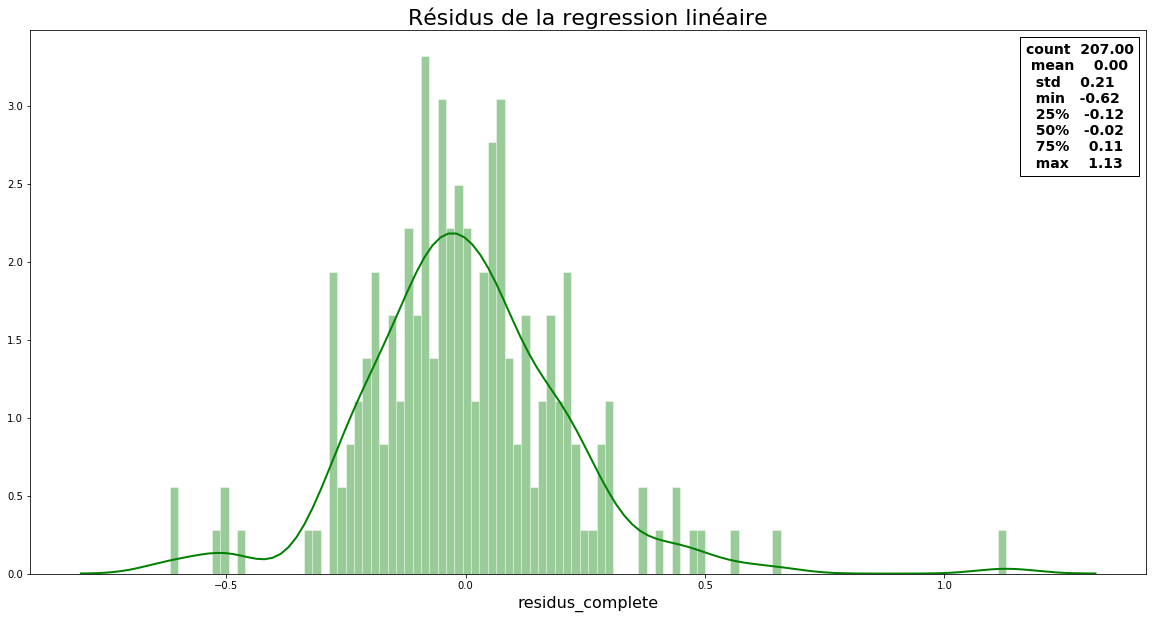

                              OLS Regression Results                              
Dep. Variable:     Unemp_quasi_difference   R-squared:                       0.593
Model:                                OLS   Adj. R-squared:                  0.537
Method:                     Least Squares   F-statistic:                     10.55
Date:                    Thu, 25 Apr 2019   Prob (F-statistic):           6.24e-24
Time:                            15:19:48   Log-Likelihood:                 26.997
No. Observations:                     207   AIC:                            -1.994
Df Residuals:                         181   BIC:                             84.66
Df Model:                              25                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [107]:
# Regression lineaire 
Y = df['Unemp_quasi_difference']
X = df[['inf_quasi_difference', 'inf-1', 'inf-2', 'inf-3', 'inf-4', 'Unemp-1', 'Unemp-2', 'Unemp-3', 'Unemp-4', 'FFR_corrected','Tbill_corrected','Tb1yr_corrected','r5_corrected','r10_corrected','PPINSA_corrected','Finished_corrected','CPICORE_corrected','M1NSA_corrected','M2SA_corrected','M2NSA_corrected','IndProd_corrected','RGDP_corrected','Potent_corrected','Deflator_corrected','Curr_corrected']]
ols = sm.OLS(Y, sm.add_constant(X)).fit()

# Histogramme des résidus
df['residus_complete']= ols.resid
plot_hist(df['residus_complete'], 'residus_complete', "Résidus de la regression linéaire", bins=100, kde=True)

# OLS summary
print(ols.summary())

In [108]:
granger_test = grangercausalitytests(df[['Unemp_quasi_difference', 'inf_quasi_difference']], maxlag = 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3769  , p=0.5400  , df_denom=203, df_num=1
ssr based chi2 test:   chi2=0.3825  , p=0.5363  , df=1
likelihood ratio test: chi2=0.3821  , p=0.5365  , df=1
parameter F test:         F=0.3769  , p=0.5400  , df_denom=203, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6312  , p=0.5330  , df_denom=200, df_num=2
ssr based chi2 test:   chi2=1.2939  , p=0.5236  , df=2
likelihood ratio test: chi2=1.2898  , p=0.5247  , df=2
parameter F test:         F=0.6312  , p=0.5330  , df_denom=200, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7617  , p=0.5168  , df_denom=197, df_num=3
ssr based chi2 test:   chi2=2.3662  , p=0.5000  , df=3
likelihood ratio test: chi2=2.3525  , p=0.5025  , df=3
parameter F test:         F=0.7617  , p=0.5168  , df_denom=197, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7926  , p=0.5313  

On ne peut donc pas rejeter l'hypothèse qu'il n'y a pas de lien de causation entre l'inflation et le chomage.

## Question 12
Représentez graphiquement les délais distribués et commentez. Calculer l’impact à long de terme de l’inflation sur le chômage.